# 这个用于检验各种特征转换的效果，统一采用LGB模型，并进行五折交叉验证

## Loading the library

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import QuantileTransformer,MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

## Loading the DataSet

In [2]:
train_df = pd.read_csv("../SantanderData/train.csv")
test_df = pd.read_csv("../SantanderData/test.csv")

## Getting the raw feature and target

In [3]:
features = train_df.columns.values[2:]
train_X = train_df[features].values
train_Y = train_df['target'].values
test_X = test_df[features].values

## Setting the function of transform

In [4]:
def feature_transform(train_X,test_X,transform_type):
    transformer = {'QT':QuantileTransformer(),'MM':MinMaxScaler(),'SS':StandardScaler()}
    t_train_X = transformer[transform_type].fit_transform(train_X)
    t_test_X = transformer[transform_type].fit_transform(test_X)
    return t_train_X,t_test_X

## Setting the model and params

In [5]:
params = {
        'num_leaves': 10,
        'max_bin': 119,
        'min_data_in_leaf': 11,
        'learning_rate': 0.02,
        'min_sum_hessian_in_leaf': 0.00245,
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': 0.05,
        'lambda_l1': 4.972,
        'lambda_l2': 2.276,
        'min_gain_to_split': 0.65,
        'max_depth': 14,
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0
}

In [6]:
def model(train_X,train_Y,test_X,params,features,transform_type,nfold = 5):
        skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=2019)
        oof = np.zeros(len(train_X))
        predictions = np.zeros(len(test_X))
        feature_importance_df = pd.DataFrame()
        i = 1
        for train_index, valid_index in skf.split(train_X, train_Y):
            print("\nfold {}".format(i))

            xg_train = lgb.Dataset(train_X[train_index, :],
                                   label=train_Y[train_index],
                                   free_raw_data=False
                                   )
            xg_valid = lgb.Dataset(train_X[valid_index, :],
                                   label=train_Y[valid_index],
                                   free_raw_data=False
                                   )
            evals_result = {} #record the result for metric plotting
            clf = lgb.train(params, xg_train, 15000, valid_sets=[xg_train,xg_valid], verbose_eval=1000, early_stopping_rounds=250,evals_result=evals_result)
            plt.figure(figsize=(12, 6))
            lgb.plot_metric(evals_result, metric='auc')
            plt.title("Metric")
            plt.savefig("figure/Metric{:}{:}.png".format(i,transform_type))
            oof[valid_index] = clf.predict(train_X[valid_index, :], num_iteration=clf.best_iteration)
            #print("fold{:}'s roc is: {:<0.5f}".format(i,roc_auc_score(oof[valid_index],self.train_Y[valid_index])))
            fold_importance_df = pd.DataFrame()
            fold_importance_df["Feature"] = features
            fold_importance_df["importance"] = clf.feature_importance()
            fold_importance_df["fold"] = i
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            predictions += clf.predict(test_X, num_iteration=clf.best_iteration) / nfold
            i = i + 1
        CVScore = roc_auc_score(train_Y, oof)
        return CVScore,feature_importance_df,predictions

## Plotting the feature importance

## Start training


fold 1
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.904023	valid_1's auc: 0.885467
[2000]	training's auc: 0.920194	valid_1's auc: 0.894343
[3000]	training's auc: 0.93036	valid_1's auc: 0.898123
[4000]	training's auc: 0.937844	valid_1's auc: 0.899242
[5000]	training's auc: 0.944451	valid_1's auc: 0.899647
Early stopping, best iteration is:
[5359]	training's auc: 0.946684	valid_1's auc: 0.89985

fold 2
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.90429	valid_1's auc: 0.881143
[2000]	training's auc: 0.920373	valid_1's auc: 0.890459
[3000]	training's auc: 0.930447	valid_1's auc: 0.894494
[4000]	training's auc: 0.937946	valid_1's auc: 0.896397
[5000]	training's auc: 0.944554	valid_1's auc: 0.89699
Early stopping, best iteration is:
[5103]	training's auc: 0.945216	valid_1's auc: 0.89702

fold 3
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.904008	valid_1's auc: 0.8

<Figure size 864x432 with 0 Axes>

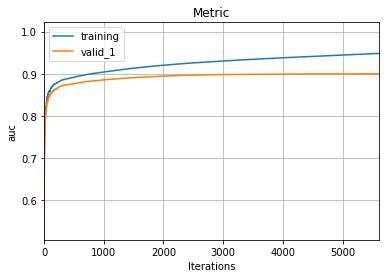

<Figure size 864x432 with 0 Axes>

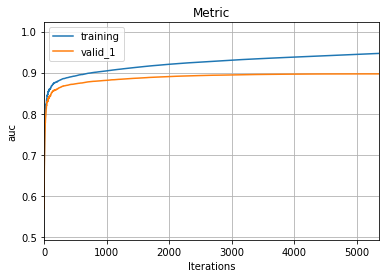

<Figure size 864x432 with 0 Axes>

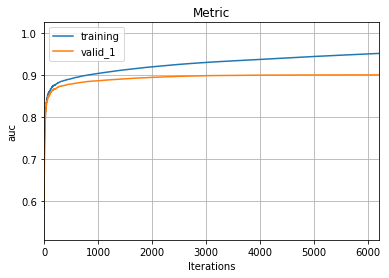

<Figure size 864x432 with 0 Axes>

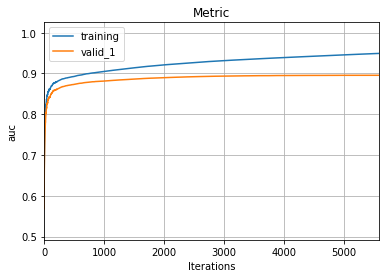

<Figure size 864x432 with 0 Axes>

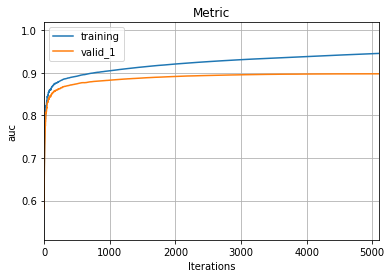

In [8]:
transform_type = 'default'
CVScore,feature_importance_df,predictions = model(train_X,train_Y,test_X,params,features,transform_type)
print("final CV:{:<0.5f}".format(CVScore))
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("../SantanderData/submission_{:}.csv".format(transform_type), index=False)

C:\Users\18351\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


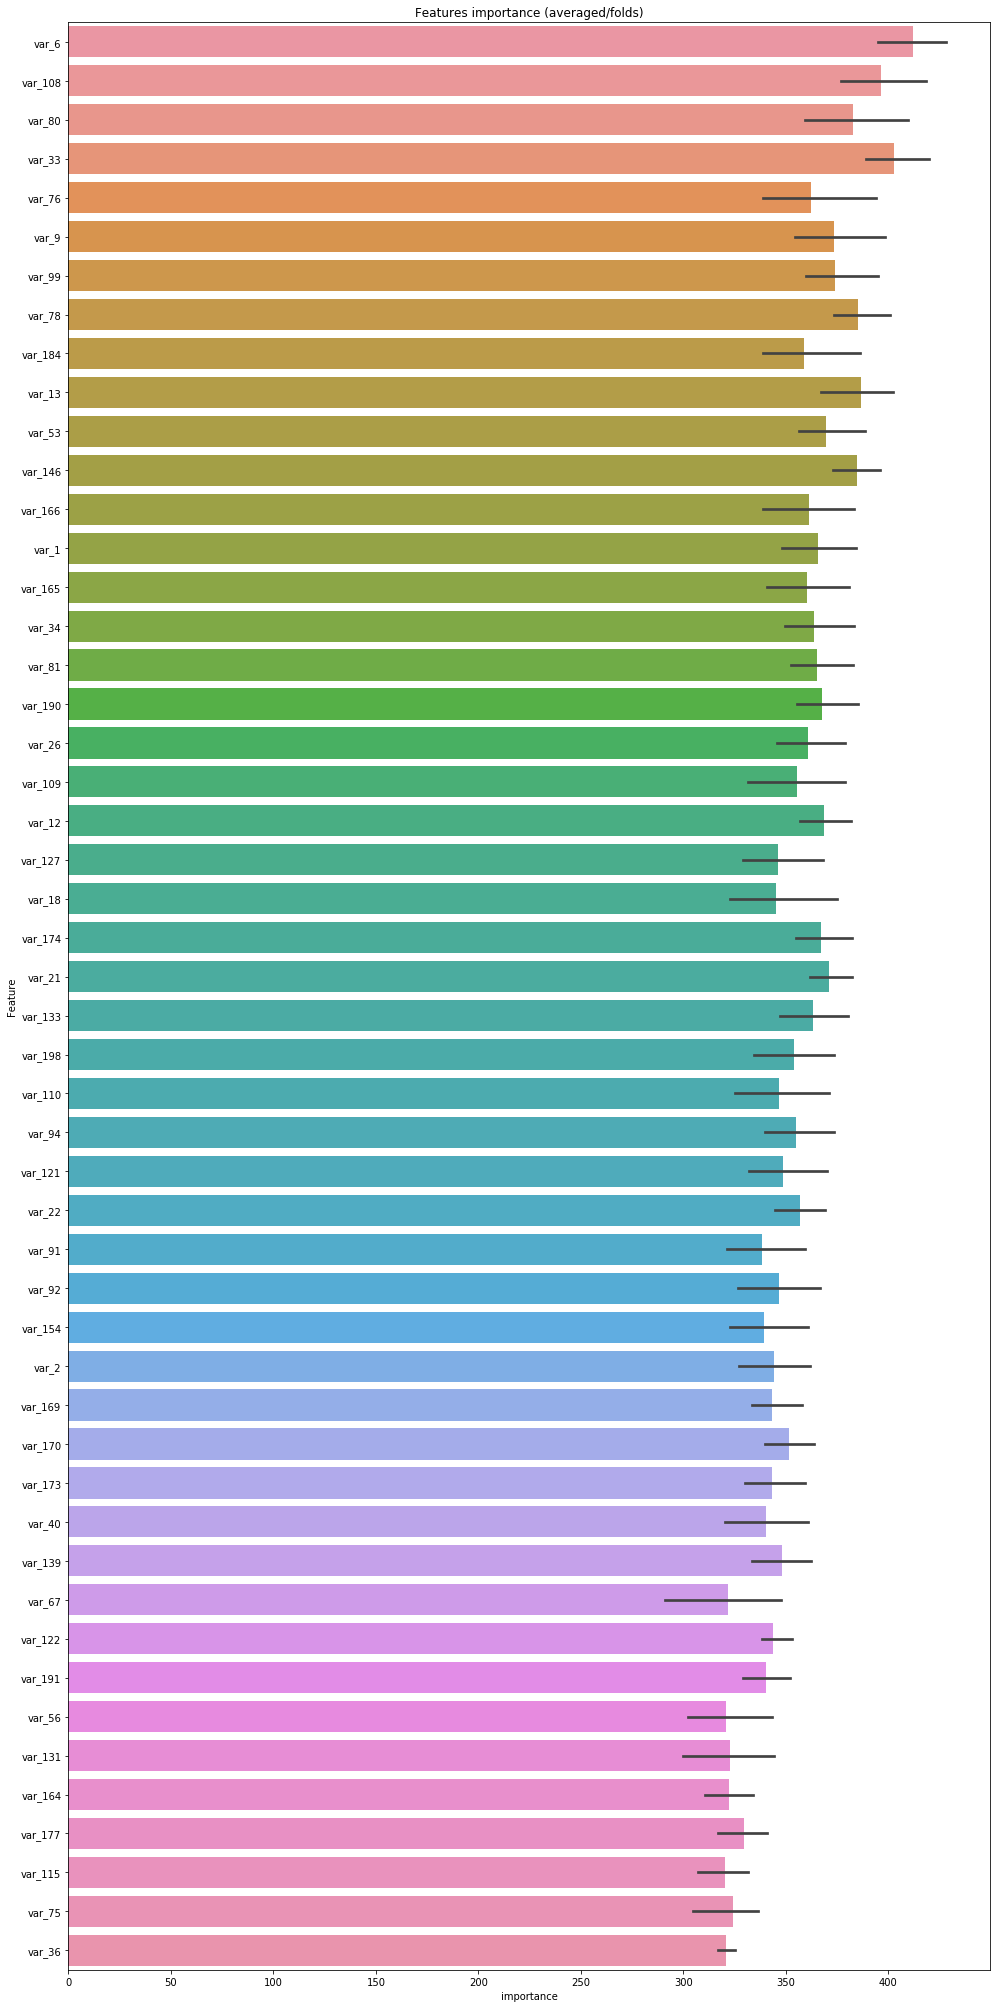

In [9]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[0:50].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
plt.figure(figsize=(14, 28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('figure/FI{:}.png'.format(transform_type))

In [1]:
Top50_features = best_features.sort_values(by="importance",ascending = False)["Feature"].values[:100]

NameError: name 'best_features' is not defined

In [18]:
Top50_features.shape

(50,)